# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [16]:
import tensorflow as tf
from scipy.io import loadmat
import cv2
from scipy.ndimage.measurements import center_of_mass

In [17]:
def centralize(image):
    center_y, center_x = center_of_mass(image)
    rows, cols = image.shape
    x_shift = np.round(cols / 2.0 - center_x).astype(int)
    y_shift = np.round(rows / 2.0 - center_y).astype(int)

    matrix = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    dst = cv2.warpAffine(image, matrix, (cols, rows))
    return dst

<img src='data/svhn_examples.jpg'/>
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [18]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [19]:
import random
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers, activations
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

%matplotlib inline
plt.style.use('seaborn')

In [20]:
# Extracting the training and testing images and their labels

X, y = train['X'] / 255., train['y']
X_test, y_test = test['X'] / 255., test['y']

assert np.max(X[0]) <= 1
assert np.max(X_test[0]) <= 1

print(f'Shape of the Training images {X.shape}')
print(f'Shape of the Training labels {y.shape}')
print('-'*50)
print(f'Shape of the Test images {X_test.shape}')
print(f'Shape of the Test labels {y_test.shape}')

Shape of the Training images (32, 32, 3, 73257)
Shape of the Training labels (73257, 1)
--------------------------------------------------
Shape of the Test images (32, 32, 3, 26032)
Shape of the Test labels (26032, 1)


In [21]:
# Reshaping the training and test images

X = np.moveaxis(X, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)

# If we look at the unique labels present in the dataset we find that there is no 0
# In the dataset 0 is labelled as 10, so we need to convert it back to 0 to train our model

print(f'{np.unique(y)}\nAs we can see the labels are 1-10 so we change them to 0-9 to match our softmax output')
y[np.where(y == 10)] = 0
y_test[np.where(y_test == 10)] = 0
print(f'Changing the label 10 to 0...\n{np.unique(y)}')


print(f'After reshaping the shapes are\nTrain : {X.shape}\nTest : {X_test.shape}')
print(f'\nAfter reshaping the shapes are\nTrain-Labels : {y.shape}\nTest-Labels : {y_test.shape}')

[ 1  2  3  4  5  6  7  8  9 10]
As we can see the labels are 1-10 so we change them to 0-9 to match our softmax output
Changing the label 10 to 0...
[0 1 2 3 4 5 6 7 8 9]
After reshaping the shapes are
Train : (73257, 32, 32, 3)
Test : (26032, 32, 32, 3)

After reshaping the shapes are
Train-Labels : (73257, 1)
Test-Labels : (26032, 1)


In [22]:
# A function that plots images, if grayscale plots as binary else plots as RGB

def plot_images(random_indexes, nrows, ncols, grayscale=False):
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))

    index = 0
    for i in range(nrows):
        for j in range(ncols):
            img = np.squeeze(X[random_indexes[index]])
            
            if grayscale:
                axes[i, j].imshow(img, cmap='binary')
            else:
                axes[i, j].imshow(img)
                
            axes[i, j].set_title(str(y[random_indexes[index]]), fontsize=20)
                
            index += 1

    fig.tight_layout()
    plt.show()

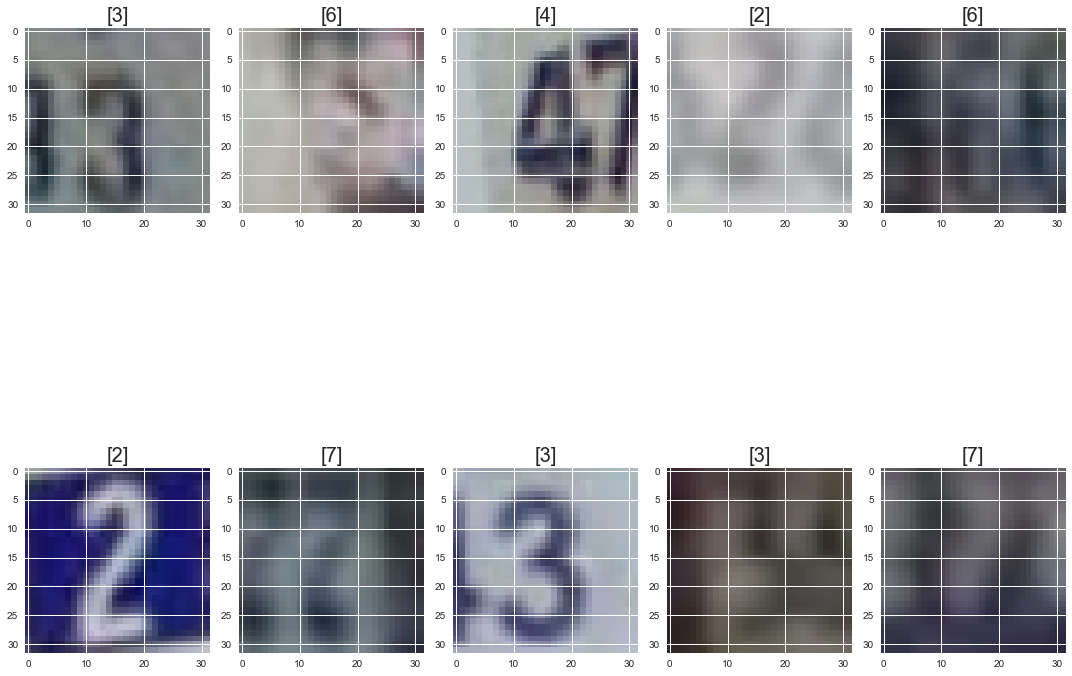

In [23]:
# Displaying 10 random images from the training set
# This same 10 images will also be displayed when the images are converted into grayscale (single channel)

random_indexes = [random.randint(0, 73256) for _ in range(10)]
num_rows = 2
num_cols = 5

plot_images(random_indexes, num_rows, num_cols)

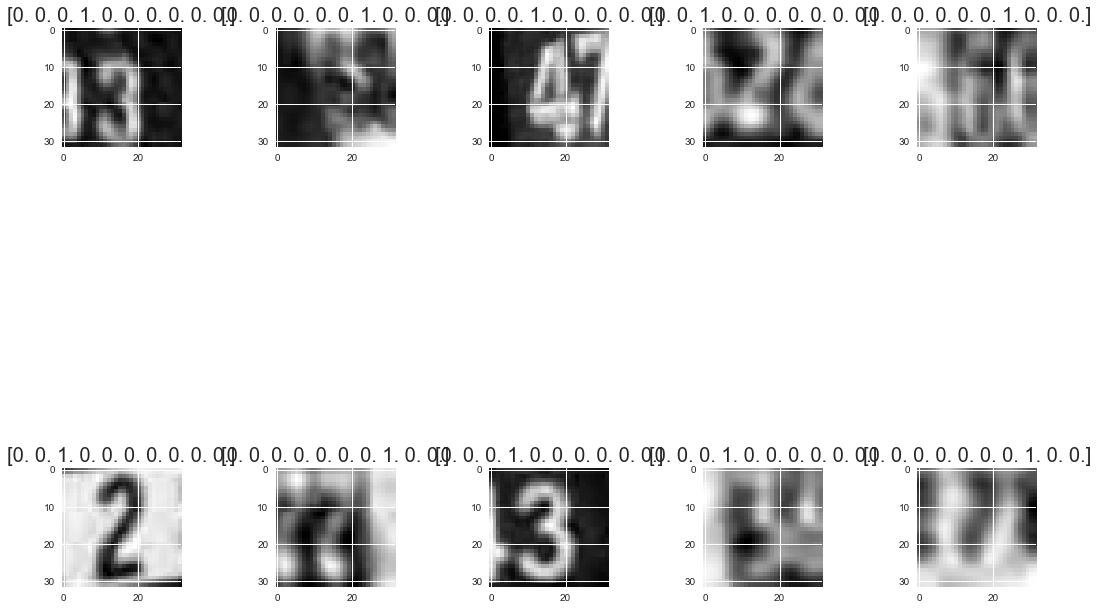

Shape of training set : (73257, 32, 32, 1) Labels : (73257, 10, 2)
Shape of test set : (26032, 32, 32, 1) Labels : (26032, 10, 2)


In [35]:
# Grayscaling the images (One-Channel)
# Taking the mean of images over the 3rd axis

X = np.mean(X, -1, keepdims=True)
X_test = np.mean(X_test, -1, keepdims=True)

plot_images(random_indexes, num_rows, num_cols, True)

y = to_categorical(y)
y_test = to_categorical(y_test)

print(f'Shape of training set : {X.shape} Labels : {y.shape}')
print(f'Shape of test set : {X_test.shape} Labels : {y_test.shape}')

In [36]:
_, thresh = cv2.threshold(X[0], 255, 255, cv2.THRESH_BINARY)
cv2.imshow('Read', thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [9]:
model = Sequential([
    Flatten(input_shape=(32, 32, 1)),
    Dense(128, activation='relu', name='MLPDense-1'),
    Dense(128, activation='relu', name='MLPDense-2'), 
    Dense(128, activation='relu', name='MLPDense-3'), 
    Dense(256, activation='relu', name='MLPDense-4'), 
    Dense(10, activation='softmax', name='MLPOut')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
MLPDense-1 (Dense)           (None, 128)               131200    
_________________________________________________________________
MLPDense-2 (Dense)           (None, 128)               16512     
_________________________________________________________________
MLPDense-3 (Dense)           (None, 128)               16512     
_________________________________________________________________
MLPDense-4 (Dense)           (None, 256)               33024     
_________________________________________________________________
MLPOut (Dense)               (None, 10)                2570      
Total params: 199,818
Trainable params: 199,818
Non-trainable params: 0
__________________________________________________

In [11]:
class StopTrainingCallback(Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if accuracy >= 0.95 or val_accuracy >= 0.93:
            print(f'Currently in epoch-{epoch}')
            print(f'Reached a Training Accuracy of {accuracy} and Validation Accuracy of {val_accuracy}...Training will be stopped to prevent overfitting')
            self.model.stop_training = True

model_best_val = ModelCheckpoint('model_best_val/checkpoint', monitor='val_loss', 
                                 save_weights_only=True, save_best_only=True)

stop_training = StopTrainingCallback()

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.05, patience=10, verbose=1)
            

In [12]:
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(X, y, epochs=30, batch_size=64,   
                    validation_split=0.08, callbacks=[model_best_val, stop_training])

Epoch 1/30
1054/1054 [==============================] - 4s 4ms/step - loss: 2.1374 - accuracy: 0.2395 - val_loss: 2.0646 - val_accuracy: 0.2624
Epoch 2/30
1054/1054 [==============================] - 4s 3ms/step - loss: 1.7905 - accuracy: 0.3824 - val_loss: 1.8187 - val_accuracy: 0.3592
Epoch 3/30
1054/1054 [==============================] - 3s 3ms/step - loss: 1.6083 - accuracy: 0.4568 - val_loss: 1.5906 - val_accuracy: 0.4730
Epoch 4/30
1054/1054 [==============================] - 4s 4ms/step - loss: 1.5188 - accuracy: 0.4976 - val_loss: 1.5295 - val_accuracy: 0.4897
Epoch 5/30
1054/1054 [==============================] - 3s 2ms/step - loss: 1.4602 - accuracy: 0.5239 - val_loss: 1.4854 - val_accuracy: 0.5195
Epoch 6/30
1054/1054 [==============================] - 3s 3ms/step - loss: 1.4114 - accuracy: 0.5445 - val_loss: 1.4900 - val_accuracy: 0.5013
Epoch 7/30
1054/1054 [==============================] - 4s 4ms/step - loss: 1.3730 - accuracy: 0.5620 - val_loss: 1.3956 - val_accuracy:

In [14]:
df = pd.DataFrame(history.history)
df.head()

,loss,accuracy,val_loss,val_accuracy
0,2.137377,0.239450,2.064631,0.262413
1,1.790484,0.382352,1.818658,0.359154
2,1.608270,0.456822,1.590649,0.472957
3,1.518822,0.497641,1.529516,0.489678
4,1.460203,0.523874,1.485369,0.519536


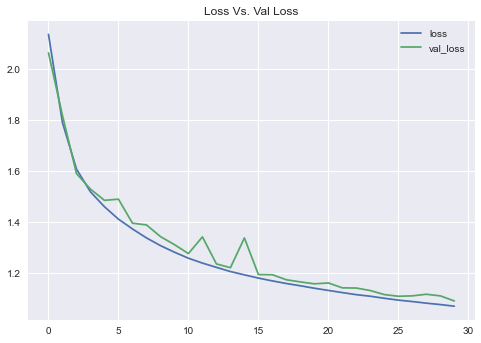

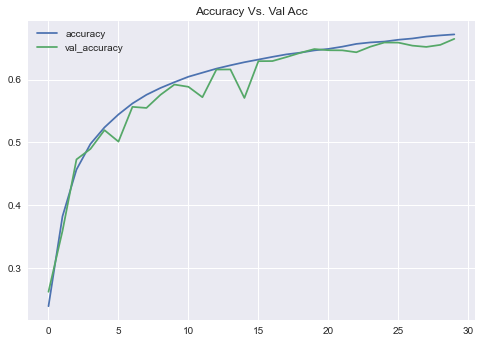

In [15]:
df.plot(y=['loss', 'val_loss'], legend=True, title='Loss Vs. Val Loss')
df.plot(y=['accuracy', 'val_accuracy'], legend=True, title='Accuracy Vs. Val Acc')
plt.show()

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=False)
print(f'The model scored a loss of {test_loss} and an accuracy of {test_acc} on the test set of size {len(X_test)}')

The model scored a loss of 1.1874489784240723 and an accuracy of 0.6391748785972595 on the test set of size 26032


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [17]:
early_stopping_conv = EarlyStopping(monitor='loss', min_delta=0.01, patience=3, verbose=1)

In [18]:
conv_model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 1), padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(10, activation='softmax')
])

In [19]:
conv_model.summary()
conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [20]:
conv_model_best_val = ModelCheckpoint('conv_model_best_val/checkpoint', monitor='val_loss', 
                                 save_weights_only=True, save_best_only=True)

In [21]:
conv_history = conv_model.fit(X, y, epochs=30,  
                    validation_split=0.08,
                    callbacks=[conv_model_best_val, stop_training])

Epoch 1/30
2107/2107 [==============================] - 59s 28ms/step - loss: 1.2104 - accuracy: 0.5916 - val_loss: 0.5341 - val_accuracy: 0.8340
Epoch 2/30
2107/2107 [==============================] - 60s 28ms/step - loss: 0.7018 - accuracy: 0.7832 - val_loss: 0.4788 - val_accuracy: 0.8562
Epoch 3/30
2107/2107 [==============================] - 58s 28ms/step - loss: 0.6295 - accuracy: 0.8055 - val_loss: 0.4572 - val_accuracy: 0.8587
Epoch 4/30
2107/2107 [==============================] - 59s 28ms/step - loss: 0.5938 - accuracy: 0.8196 - val_loss: 0.4306 - val_accuracy: 0.8669
Epoch 5/30
2107/2107 [==============================] - 59s 28ms/step - loss: 0.5668 - accuracy: 0.8280 - val_loss: 0.3937 - val_accuracy: 0.8773
Epoch 6/30
2107/2107 [==============================] - 62s 29ms/step - loss: 0.5529 - accuracy: 0.8322 - val_loss: 0.3911 - val_accuracy: 0.8814
Epoch 7/30
2107/2107 [==============================] - 59s 28ms/step - loss: 0.5351 - accuracy: 0.8381 - val_loss: 0.4235 -

In [22]:
conv_df = pd.DataFrame(conv_history.history)
conv_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.210446,0.591563,0.534120,0.833987
1,0.701846,0.783207,0.478764,0.856168
2,0.629514,0.805493,0.457236,0.858727
3,0.593787,0.819589,0.430626,0.866917
4,0.566829,0.828046,0.393708,0.877325


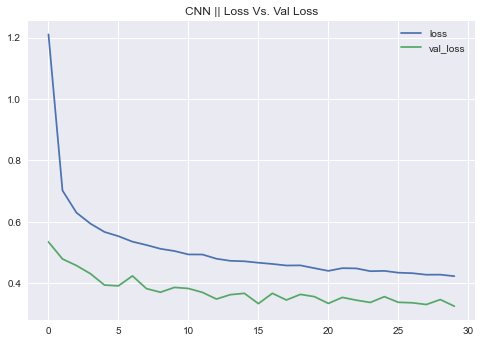

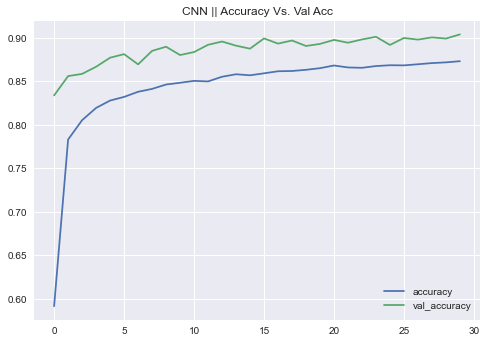

In [23]:
conv_df.plot(y=['loss', 'val_loss'], legend=True, title='CNN || Loss Vs. Val Loss')
conv_df.plot(y=['accuracy', 'val_accuracy'], legend=True, title='CNN || Accuracy Vs. Val Acc')
plt.show()

In [24]:
conv_loss, conv_accuracy = conv_model.evaluate(X_test, y_test, verbose=False)
print(f'The Convolutional model scored a loss of {conv_loss} and accuracy of {conv_accuracy}')

The Convolutional model scored a loss of 0.37199723720550537 and accuracy of 0.8925937414169312


### 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [28]:
model.load_weights('model_best_val/checkpoint')
conv_model.load_weights('conv_model_best_val/checkpoint')

print('Best weights loaded for MLP model and Conv Model!')

Best weights loaded for MLP model and Conv Model!


In [29]:
mlp_loss, mlp_acc = model.evaluate(X_test, y_test, verbose=False)
convolution_loss, convolution_acc = conv_model.evaluate(X_test, y_test, verbose=False)

print(f'The Loss of MLP is {mlp_loss} and the Accuracy of MLP is {mlp_acc}')
print(f'The Loss of CNN is {convolution_loss} and the Accuracy of CNN is {convolution_acc}')

The Loss of MLP is 1.1874489784240723 and the Accuracy of MLP is 0.6391748785972595
The Loss of CNN is 0.37199723720550537 and the Accuracy of CNN is 0.8925937414169312


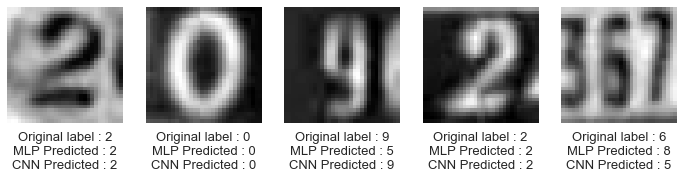

In [171]:
rand_idxs = [random.randint(0, 26031) for _ in range(5)]

imgs = [X_test[i] for i in rand_idxs]
labels = [y_test[i] for i in rand_idxs]
mlp_predictions = model.predict(np.array(imgs))
conv_predictions = conv_model.predict(np.array(imgs))

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i in range(5):
    axes[i].imshow(np.squeeze(imgs[i]), cmap='binary')
    axes[i].grid(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    display_str = f"Original label : {np.argmax(labels[i])}\nMLP Predicted : {np.argmax(mlp_predictions[i])}\nCNN Predicted : {np.argmax(conv_predictions[i])}"
    axes[i].text(0.5, -0.4, display_str, size=13, ha="center", 
         transform=axes[i].transAxes)

plt.show()

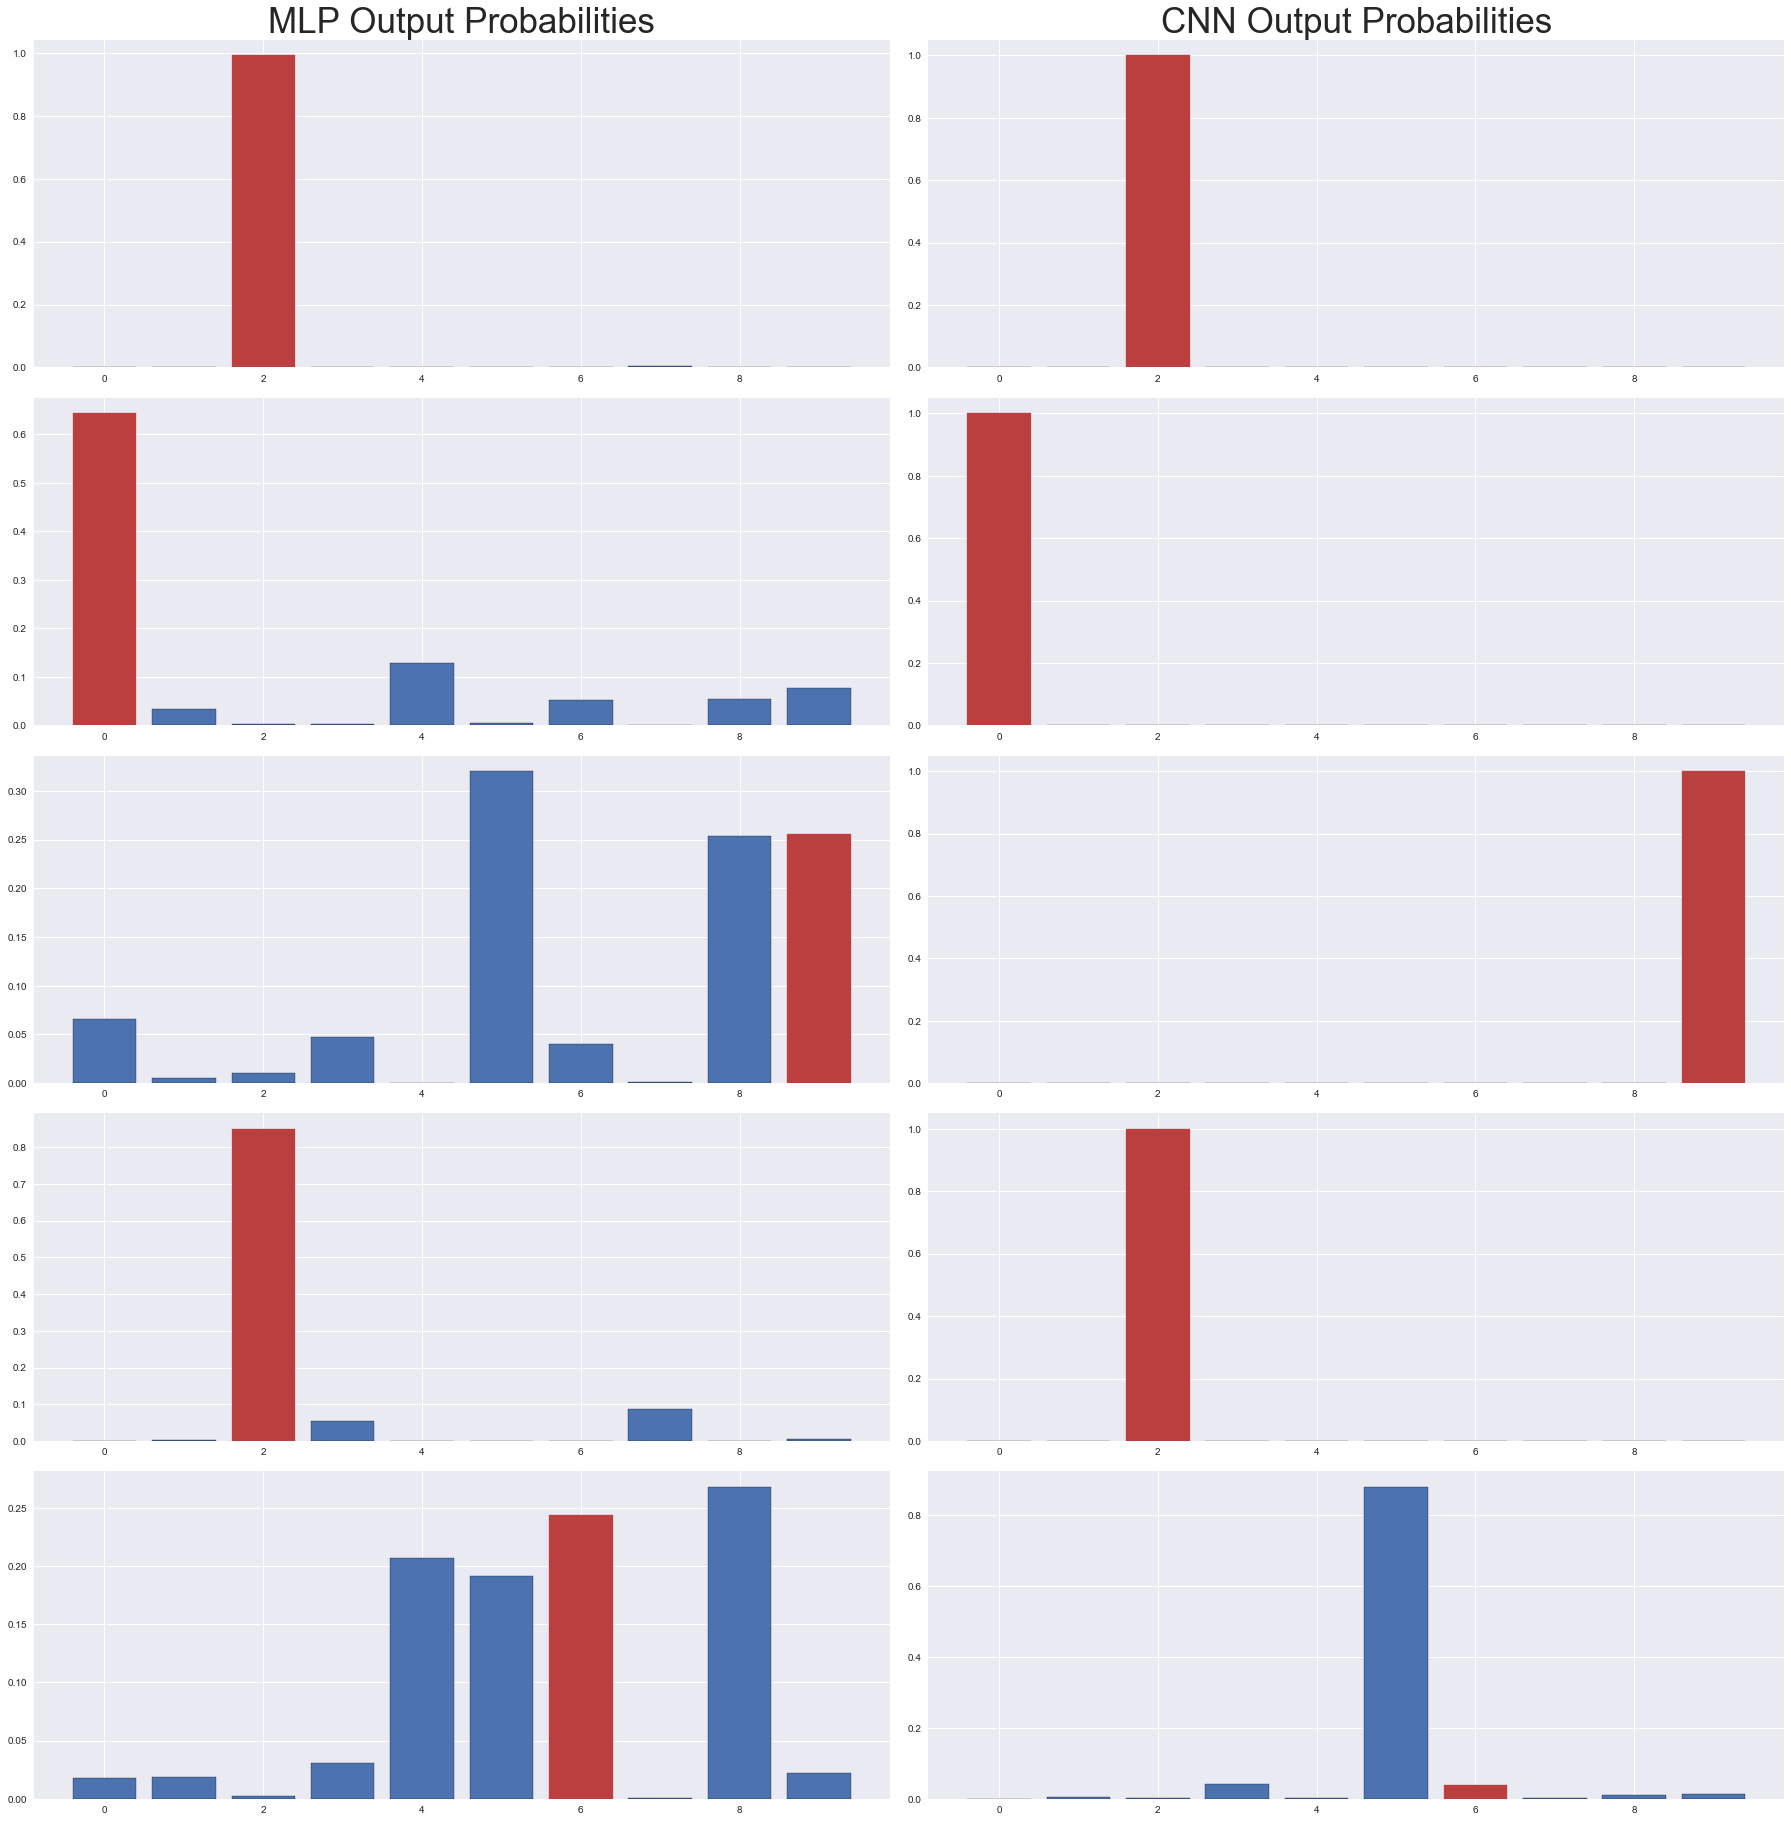

The above distributions correspond to the 5 images shown earlier, the correct label is shown in red color


In [172]:
# Predictions distribution
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(25, 25))

fig.tight_layout()

axes[0][0].set_title('MLP Output Probabilities', fontsize=35)
axes[0][1].set_title('CNN Output Probabilities', fontsize=35)

for i in range(5):
        mlp_bars = axes[i, 0].bar(list(range(10)), mlp_predictions[i], edgecolor='black')
        conv_bars = axes[i, 1].bar(list(range(10)), conv_predictions[i], edgecolor='black')
        
        mlp_bars[np.argmax(labels[i])].set_color('#bb3f3f')
        conv_bars[np.argmax(labels[i])].set_color('#bb3f3f')
        
plt.show()

print('The above distributions correspond to the 5 images shown earlier, the correct label is shown in red color')

## I loved the course!
## Thanks in advance for reviewing my capstone project

## Any kind of suggestions will be appreciated : )